# Simulations with SPAM errors

## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced SPAM errors and here we will go in deeper details. We recommend that you check the introductory tutorial about Noise and Errors before going through this one.

The SPAM errors or State Preparation And Measurement errors encapsulates errors, as its name indicates, are some errors that occurs during state preparation and measurements. There are three types of such errors:
* One (with probability $\eta$) which represents the amount of atoms not trapped in the ground state so are in the excited state
* The two others, (with probabilities $\epsilon, \epsilon '$) are linked to detection errors. During the imaging process, excited Rydberg atoms in $\Ket{r}$ might decay to the state $\Ket{g}$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. On the contrary, some atoms in $\Ket{g}$ might get excited due to various causes (collisions...) and tweezer recapture might fail, inferring them incorrectly as atoms in $\Ket{r}$ : those are the false positives modeled by $\epsilon$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

## Single atom noisy simulations

### Sequence preparation

Prepare a single atom:

In [2]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

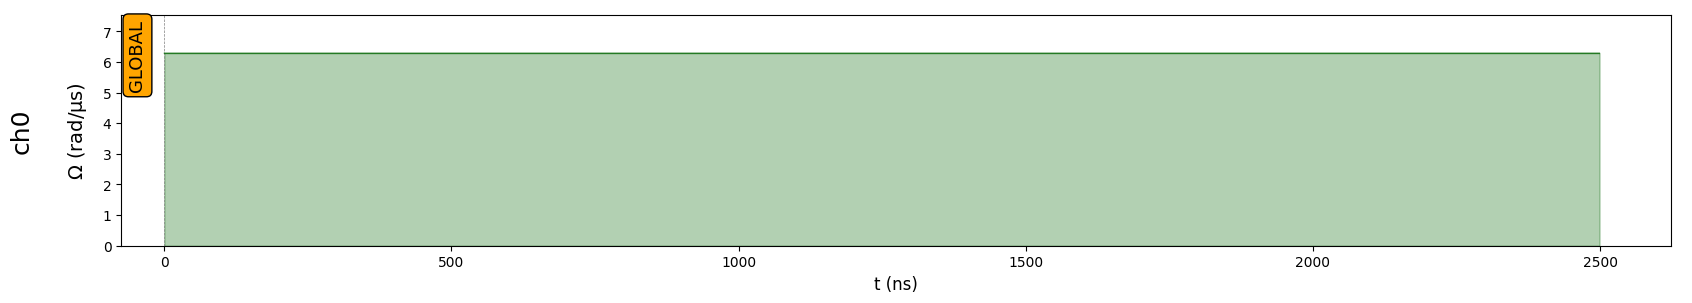

In [3]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

We now create the simulation object

In [4]:
sim = Simulation(seq, sampling_rate=0.05)

We instantiate an observable which describes the excited state population

In [5]:
obs = qutip.basis(2, 0).proj()

In [6]:
sim.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


## SPAM effects

Compare both clean and noisy simulations for the default SPAM parameters (taken from [De Léséleuc, et al., 2018](https://arxiv.org/abs/1802.10424))

In [7]:
# Define SPAM configuration:
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)

# Apply the configuration to the simulation and run it:
sim.set_config(config_spam)
sim.show_config()

# Run the simulation storing 40% of the results:
sim.evaluation_times = 0.4
res_spam = sim.run()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


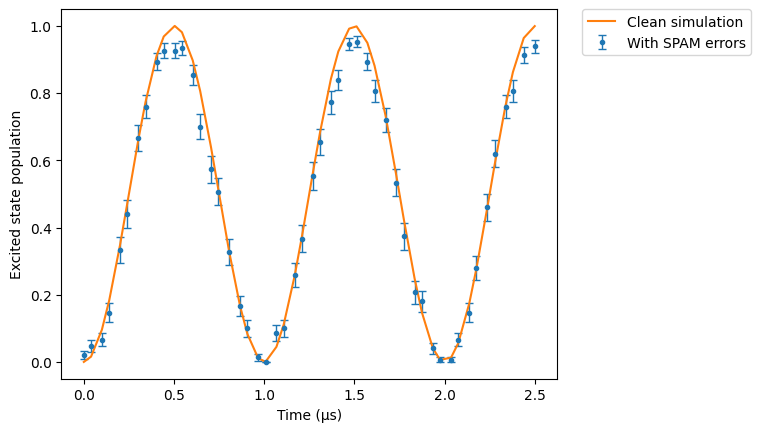

In [8]:
res_spam.plot(obs, label="With SPAM errors")

# Now run the clean simulation:
sim.reset_config()
res_clean = sim.run()
res_clean.plot(obs, label="Clean simulation")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

We will now modify the *SPAM* dictionary, as below, allowing for more ($40$%) badly prepared atoms.

Text(0, 0.5, 'Excited state population')

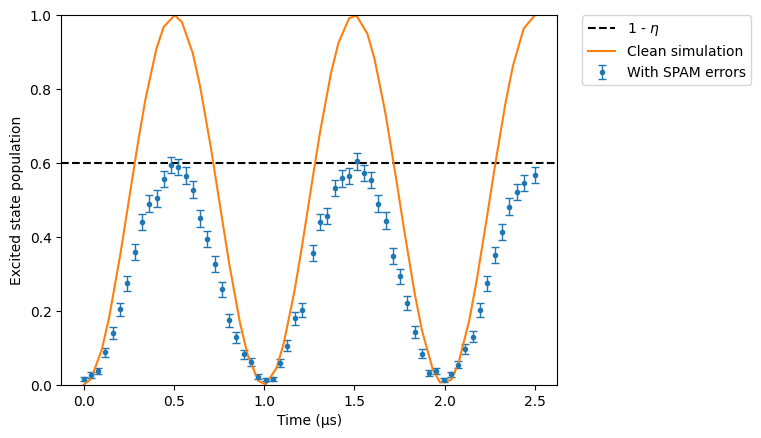

In [15]:
config_spam_mod = SimConfig(noise=("SPAM"), eta=0.4, runs=100)
sim.set_config(config_spam_mod)
sim.evaluation_times = 0.5
res_large_eta = sim.run()

plt.figure()
plt.ylim(0, 1)
plt.axhline(
    1 - config_spam_mod.eta, color="black", linestyle="--", label=r"1 - $\eta$"
)
res_large_eta.plot(obs, label="With SPAM errors")
res_clean.plot(obs, label="Clean simulation")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")

We can see here that the population doesn't go well above $0.6 = 1 - \eta$, which is to be expected : badly prepared atoms don't reach state $\Ket{r}$. We can expect this limit of $0.6$ in the Rydberg population to be more and more respected as the number of runs grows.

## Changing $\eta$

Let us first initialize all spam error values to $0$. Then, we do a sweep over the parameter $\eta$, probability of badly prepared states, to notice its effects.

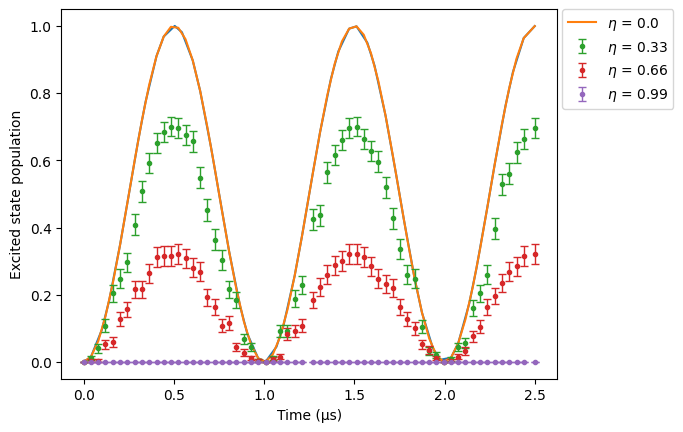

In [16]:
res_clean.plot(obs)
for eta in np.linspace(0, 0.99, 4):
    config_spam_eta = SimConfig(
        noise="SPAM", eta=eta, runs=50, epsilon=0, epsilon_prime=0
    )
    sim.set_config(config_spam_eta)
    sim.run().plot(obs, label=rf"$\eta$ = {eta}")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

As $\eta$ grows, more qubits are not well-prepared (i.e, pumped into a state different from $\Ket{g}$) and we stop seeing occupations at all. You may increase the number of runs to smooth the curves.

### Changing $\epsilon$ and $\epsilon'$

Let's now compare sweeps over $\epsilon$ and $\epsilon'$ side by side:

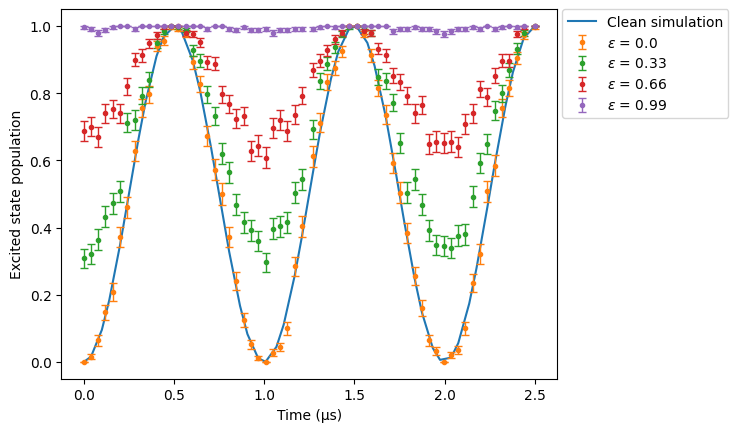

In [17]:
res_clean.plot(obs, label="Clean simulation")
for eps in np.linspace(0, 0.99, 4):
    config_spam_eps = SimConfig(
        noise="SPAM", eta=1e-8, runs=50, epsilon=eps, epsilon_prime=0
    )
    sim.set_config(config_spam_eps)
    sim.run().plot(obs, label=rf"$\epsilon$ = {eps}")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

As more false positives appear, it looks like the system is never captured, so always in a Rydberg state. Note that when $\eta=0$, the object we obtain is a `CoherentResults` rather than a `NoisyResults`, since in this case, the randomness comes from measurements and the simulation is entirely deterministic. This results in smooth curves rather than scattered dots.

Finally, we sweep over the $\epsilon '$ values:

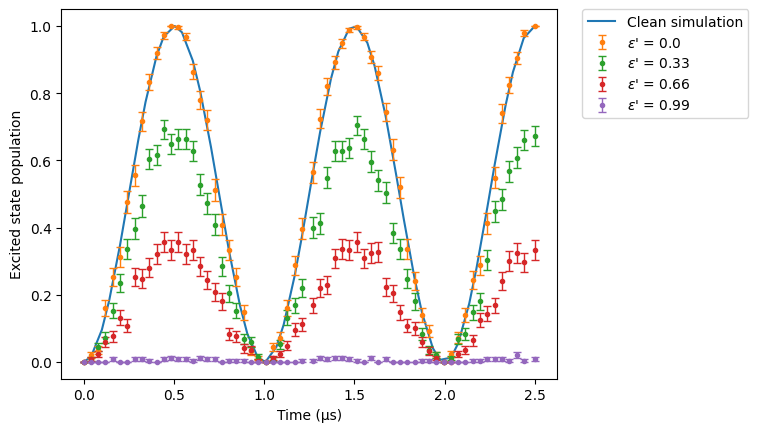

In [20]:
res_clean.plot(obs, label="Clean simulation")
for eps_p in np.linspace(0, 0.99, 4):
    config_spam_eps_p = SimConfig(
        noise="SPAM", eta=1e-8, runs=50, epsilon=0, epsilon_prime=eps_p
    )
    sim.set_config(config_spam_eps_p)
    sim.run().plot(obs, label=rf"$\epsilon$' = {eps_p}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

As there are more false negatives, all atoms seem to be recaptured, until no Rydberg occupation is detected.